In [4]:
import numpy as np
import pandas as pd 
import zipfile
import wget
from datetime import date
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from pickle import load
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## Downloading Data Sets

In [5]:
#reading csv file from a zip file 
zf = zipfile.ZipFile('updated_datas/18.03.2021/soccer-spi.zip')
raw_data=pd.read_csv(zf.open("soccer-spi/spi_matches_latest.csv"))

#extracting only "Turkish Turkcell Super Lig" informations
super_lig_index = raw_data["league"][lambda x: x == "Turkish Turkcell Super Lig" ].index
super_lig_data = raw_data.loc[super_lig_index]

#Creating new data set with relevant data features
super_lig_spi= super_lig_data.iloc[ : , : 17 ]
super_lig_spi = super_lig_spi.reset_index().drop(labels="index",axis=1)

# Reshaping the date format
super_lig_spi["date"]= super_lig_spi.apply(lambda row: "/".join(row["date"].split("-")[::-1])[0:6] + "/".join(row["date"].split("-")[::-1])[-2:], axis=1)

super_lig_spi=super_lig_spi.rename(mapper={"team1":"HomeTeam","team2":"AwayTeam"},axis=1)
super_lig_spi["Above 2.5 Score "]= super_lig_spi.apply(lambda row: 1 if (row["score1"]+row["score2"]>2.5) else 0,axis=1)
updated_2021_2020= super_lig_spi.copy()

matches_to_predict = updated_2021_2020.loc[278 : 299].reset_index(drop = True)

matches_to_predict



,season,date,league_id,league,HomeTeam,AwayTeam,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,Above 2.5 Score
0,2020,04/03/21,1882,Turkish Turkcell Super Lig,Alanyaspor,Goztepe,48.44,41.64,0.5180,0.2186,0.2634,1.57,0.92,0.7,1.6,1.0,1.0,0
1,2020,04/03/21,1882,Turkish Turkcell Super Lig,Fenerbahce,Antalyaspor,58.09,37.24,0.7035,0.0827,0.2137,1.84,0.45,70.6,3.4,1.0,1.0,0
2,2020,06/03/21,1882,Turkish Turkcell Super Lig,Denizlispor,Yeni Malatyaspor,26.76,36.12,0.3596,0.3531,0.2873,1.21,1.19,38.8,22.8,3.0,2.0,1
3,2020,06/03/21,1882,Turkish Turkcell Super Lig,Besiktas,Gazisehir Gaziantep,65.02,44.89,0.7261,0.0895,0.1844,2.16,0.61,90.9,0.1,2.0,1.0,1
4,2020,07/03/21,1882,Turkish Turkcell Super Lig,Fatih Karagümrük,Ankaragucu,41.07,31.56,0.5104,0.2439,0.2457,1.75,1.13,0.0,54.7,0.0,1.0,0
5,2020,07/03/21,1882,Turkish Turkcell Super Lig,Hatayspor,Kayserispor,48.80,30.90,0.5817,0.1667,0.2517,1.66,0.76,1.7,49.0,1.0,3.0,1
6,2020,07/03/21,1882,Turkish Turkcell Super Lig,Genclerbirligi,Istanbul Basaksehir,25.47,38.97,0.2949,0.4407,0.2644,1.19,1.51,31.1,45.8,0.0,1.0,0
7,2020,07/03/21,1882,Turkish Turkcell Super Lig,Galatasaray,Sivasspor,63.39,43.91,0.7006,0.0921,0.2073,1.92,0.53,72.4,3.6,2.0,2.0,1
8,2020,08/03/21,1882,Turkish Turkcell Super Lig,Trabzonspor,Alanyaspor,56.70,47.87,0.5692,0.1710,0.2598,1.59,0.74,31.6,1.3,1.0,3.0,1
9,2020,08/03/21,1882,Turkish Turkcell Super Lig,Antalyaspor,Kasimpasa,38.18,35.09,0.4556,0.2552,0.2892,1.34,0.93,7.4,38.9,1.0,1.0,0


In [6]:
name_map = {'Istanbul Basaksehir' : 'Buyuksehyr', 
            'Ankaragucu' : 'Ankaragucu',  
            "Gazisehir Gaziantep" : "Gaziantep",
            'Alanyaspor' : 'Alanyaspor', 
            'Goztepe' : 'Goztep', 
            'Trabzonspor' : 'Trabzonspor', 
            'Yeni Malatyaspor' : 'Yeni Malatyaspor',
            'Besiktas' : 'Besiktas', 
            'Galatasaray' : 'Galatasaray', 
            'Kasimpasa' : 'Kasimpasa', 
            'Caykur Rizespor' : 'Rizespor', 
            "Denizlispor" : "Denizlispor",
            'Sivasspor' : 'Sivasspor', 
            "Genclerbirligi" : "Genclerbirligi", 
            'Kayserispor' : 'Kayserispor', 
            'Antalyaspor' : 'Antalyaspor',
            'Fenerbahce' : 'Fenerbahce', 
            'Konyaspor' : 'Konyaspor',
           "Fatih Karagümrük" : "Karagumruk",
            "Hatayspor" : "Hatayspor",
           "Erzurumspor" : "Erzurum BB"}

In [7]:
matches_to_predict["HomeTeam"] = matches_to_predict["HomeTeam"].map(name_map)
matches_to_predict["AwayTeam"] = matches_to_predict["AwayTeam"].map(name_map)
matches_to_predict

,season,date,league_id,league,HomeTeam,AwayTeam,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,Above 2.5 Score
0,2020,04/03/21,1882,Turkish Turkcell Super Lig,Alanyaspor,Goztep,48.44,41.64,0.5180,0.2186,0.2634,1.57,0.92,0.7,1.6,1.0,1.0,0
1,2020,04/03/21,1882,Turkish Turkcell Super Lig,Fenerbahce,Antalyaspor,58.09,37.24,0.7035,0.0827,0.2137,1.84,0.45,70.6,3.4,1.0,1.0,0
2,2020,06/03/21,1882,Turkish Turkcell Super Lig,Denizlispor,Yeni Malatyaspor,26.76,36.12,0.3596,0.3531,0.2873,1.21,1.19,38.8,22.8,3.0,2.0,1
3,2020,06/03/21,1882,Turkish Turkcell Super Lig,Besiktas,Gaziantep,65.02,44.89,0.7261,0.0895,0.1844,2.16,0.61,90.9,0.1,2.0,1.0,1
4,2020,07/03/21,1882,Turkish Turkcell Super Lig,Karagumruk,Ankaragucu,41.07,31.56,0.5104,0.2439,0.2457,1.75,1.13,0.0,54.7,0.0,1.0,0
5,2020,07/03/21,1882,Turkish Turkcell Super Lig,Hatayspor,Kayserispor,48.80,30.90,0.5817,0.1667,0.2517,1.66,0.76,1.7,49.0,1.0,3.0,1
6,2020,07/03/21,1882,Turkish Turkcell Super Lig,Genclerbirligi,Buyuksehyr,25.47,38.97,0.2949,0.4407,0.2644,1.19,1.51,31.1,45.8,0.0,1.0,0
7,2020,07/03/21,1882,Turkish Turkcell Super Lig,Galatasaray,Sivasspor,63.39,43.91,0.7006,0.0921,0.2073,1.92,0.53,72.4,3.6,2.0,2.0,1
8,2020,08/03/21,1882,Turkish Turkcell Super Lig,Trabzonspor,Alanyaspor,56.70,47.87,0.5692,0.1710,0.2598,1.59,0.74,31.6,1.3,1.0,3.0,1
9,2020,08/03/21,1882,Turkish Turkcell Super Lig,Antalyaspor,Kasimpasa,38.18,35.09,0.4556,0.2552,0.2892,1.34,0.93,7.4,38.9,1.0,1.0,0


In [8]:
#new match fixture will be added to football-data.co.uk data
adding_matches = matches_to_predict.iloc[ :, 1 : 6].rename( columns = { "date" : "Date" } )
adding_matches


,Date,league_id,league,HomeTeam,AwayTeam
0,04/03/21,1882,Turkish Turkcell Super Lig,Alanyaspor,Goztep
1,04/03/21,1882,Turkish Turkcell Super Lig,Fenerbahce,Antalyaspor
2,06/03/21,1882,Turkish Turkcell Super Lig,Denizlispor,Yeni Malatyaspor
3,06/03/21,1882,Turkish Turkcell Super Lig,Besiktas,Gaziantep
4,07/03/21,1882,Turkish Turkcell Super Lig,Karagumruk,Ankaragucu
5,07/03/21,1882,Turkish Turkcell Super Lig,Hatayspor,Kayserispor
6,07/03/21,1882,Turkish Turkcell Super Lig,Genclerbirligi,Buyuksehyr
7,07/03/21,1882,Turkish Turkcell Super Lig,Galatasaray,Sivasspor
8,08/03/21,1882,Turkish Turkcell Super Lig,Trabzonspor,Alanyaspor
9,08/03/21,1882,Turkish Turkcell Super Lig,Antalyaspor,Kasimpasa


In [9]:
def column_placer(data_set,updated_data,season ) :
    
    away_home = {"away" : "AwayTeam", "home" : "HomeTeam"}
    
    away_features = { "AW" : "W", "AD" : "D", "AL" : "L", "FTAG" : "FTG", "HTAG" : "HTG", "FTAGC" : "FTGC", "HTAGC" : "HTGC",
                     "AS" : "S", "AST" : "ST", "AF": "F", "AC" : "C", "AY" : "Y", "AR" : "R"}
    
    home_features = { "HW" : "W", "HD" : "D", "HL" : "L", "FTHG" : "FTG", "FTHGC" : "FTGC", "HTHGC" : "HTGC",
                     "HTHG" : "HTG", "HS" : "S", "HST" : "ST", "HF": "F", "HC" : "C", "HY" : "Y", "HR" : "R"}
    
    
    if away_home[data_set] == "AwayTeam":
        
        data_features = away_features
    else:
        
        data_features = home_features
    
    for feature in data_features:
        
        column_scalars= []
        
        for i in range(updated_data.shape[0]):
            team = updated_data[ away_home[data_set] ][i]
            date = updated_data["date"][i]
            data = pd.read_csv("updated_datas/updated_team_datas/{}.csv".format( team ))
            #print(date, data)
            if len(data["Date"][0])>8:
                data["Date"] = data.apply(lambda row: row["Date"][0:6] + row["Date"][-2:], axis=1)
            match_index = data["Date"][data["Date"] == date].index[0]
            
            column_scalars.append(data[data_features[feature]].loc[match_index])
                            
        updated_data[feature] = column_scalars
    

column_placer("home",matches_to_predict,"18.03.2021_datas")
column_placer("away",matches_to_predict,"18.03.2021_datas")

matches_to_predict


,season,date,league_id,league,HomeTeam,AwayTeam,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,Above 2.5 Score,HW,HD,HL,FTHG,FTHGC,HTHGC,HTHG,HS,HST,HF,HC,HY,HR,AW,AD,AL,FTAG,HTAG,FTAGC,HTAGC,AS,AST,AF,AC,AY,AR
0,2020,04/03/21,1882,Turkish Turkcell Super Lig,Alanyaspor,Goztep,48.44,41.64,0.5180,0.2186,0.2634,1.57,0.92,0.7,1.6,1.0,1.0,0,0.0,1.0,2.0,0,3,1,0,45,14,49,26,9,0,3.0,0.0,0.0,4,3,1,0,24,9,45,7,6,1
1,2020,04/03/21,1882,Turkish Turkcell Super Lig,Fenerbahce,Antalyaspor,58.09,37.24,0.7035,0.0827,0.2137,1.84,0.45,70.6,3.4,1.0,1.0,0,2.0,0.0,1.0,3,2,1,1,41,16,48,24,4,0,0.0,3.0,0.0,1,1,1,1,25,6,32,7,2,0
2,2020,06/03/21,1882,Turkish Turkcell Super Lig,Denizlispor,Yeni Malatyaspor,26.76,36.12,0.3596,0.3531,0.2873,1.21,1.19,38.8,22.8,3.0,2.0,1,1.0,0.0,2.0,1,5,3,1,24,9,41,15,5,0,0.0,1.0,2.0,3,3,5,0,28,8,37,11,4,1
3,2020,06/03/21,1882,Turkish Turkcell Super Lig,Besiktas,Gaziantep,65.02,44.89,0.7261,0.0895,0.1844,2.16,0.61,90.9,0.1,2.0,1.0,1,3.0,0.0,0.0,7,0,0,4,47,19,28,28,2,0,1.0,2.0,0.0,2,0,1,1,37,11,40,21,4,1
4,2020,07/03/21,1882,Turkish Turkcell Super Lig,Karagumruk,Ankaragucu,41.07,31.56,0.5104,0.2439,0.2457,1.75,1.13,0.0,54.7,0.0,1.0,0,1.0,1.0,1.0,6,5,2,2,29,11,34,13,5,0,1.0,1.0,1.0,4,3,6,2,28,12,48,10,11,1
5,2020,07/03/21,1882,Turkish Turkcell Super Lig,Hatayspor,Kayserispor,48.80,30.90,0.5817,0.1667,0.2517,1.66,0.76,1.7,49.0,1.0,3.0,1,2.0,1.0,0.0,8,3,1,3,34,14,50,24,6,0,1.0,1.0,1.0,2,0,3,1,37,12,44,21,6,0
6,2020,07/03/21,1882,Turkish Turkcell Super Lig,Genclerbirligi,Buyuksehyr,25.47,38.97,0.2949,0.4407,0.2644,1.19,1.51,31.1,45.8,0.0,1.0,0,0.0,1.0,2.0,2,4,2,1,39,9,46,20,6,1,0.0,2.0,1.0,1,0,2,0,22,6,29,9,3,1
7,2020,07/03/21,1882,Turkish Turkcell Super Lig,Galatasaray,Sivasspor,63.39,43.91,0.7006,0.0921,0.2073,1.92,0.53,72.4,3.6,2.0,2.0,1,2.0,0.0,1.0,4,2,1,3,26,9,43,11,7,1,1.0,2.0,0.0,3,1,1,0,40,12,44,16,6,1
8,2020,08/03/21,1882,Turkish Turkcell Super Lig,Trabzonspor,Alanyaspor,56.70,47.87,0.5692,0.1710,0.2598,1.59,0.74,31.6,1.3,1.0,3.0,1,2.0,0.0,1.0,3,2,1,1,40,8,38,13,5,0,0.0,1.0,2.0,1,0,4,2,47,14,40,29,7,0
9,2020,08/03/21,1882,Turkish Turkcell Super Lig,Antalyaspor,Kasimpasa,38.18,35.09,0.4556,0.2552,0.2892,1.34,0.93,7.4,38.9,1.0,1.0,0,0.0,3.0,0.0,1,1,0,1,21,4,40,7,7,1,1.0,0.0,2.0,4,2,5,3,32,14,35,23,4,1


## Predicting and Printing Out

In [10]:
scaler = load(open( 'Another_ML_Methods/predicting_scaler', 'rb'))
prediction_datas = matches_to_predict
data_num= prediction_datas.drop(labels = ["season" ,"date" ,"HomeTeam" ,"AwayTeam","prob2",
                                        "score1", "score2", "league", "league_id", "HTHGC", "HTAGC",
                                        "HL", "HR", "AL", "AR" ] ,axis = 1)
data_num = data_num.dropna(axis=0).reset_index(drop=True)
data_num["spi_diff"] = abs(data_num["spi1"] - data_num["spi2"] )
data_no_spis = data_num.drop(["spi1", "spi2"],axis=1)


#changing data set into ndarray
input_data = data_no_spis.drop(labels = ["Above 2.5 Score "] ,axis=1).to_numpy()
target_data = data_no_spis["Above 2.5 Score "].to_numpy()

#Support Vector Classifier
svm_1_model = load(open("Another_ML_Methods/most_acc_sv_classifier","rb"))
svm_2_model = load(open("Another_ML_Methods/svm_zero_classifier","rb"))

#Logistic Regression Classifier
LR_1_model = load(open("Another_ML_Methods/most_acc_logistic_classifier","rb"))
LR_2_model = load(open("Another_ML_Methods/cv_logistic_classifier","rb"))

#Gaussian Naive Bayesian Classifier
gnb_model = load(open("Another_ML_Methods/most_acc_nb_classifier","rb"))

#Random Forrest Classifier
forrest_model = load(open("Another_ML_Methods/most_acc_rforrest_classifier","rb"))

#Ensemble Model
ensemble_model = load(open("Another_ML_Methods/ensemble_clf","rb"))

input_scaled = scaler.transform(input_data)

#SVC Predictions
predictions_svc = svm_1_model.predict(input_scaled)
prob_svc = svm_1_model.predict_proba(input_scaled)

#GNB Predictions
predictions_gnb = gnb_model.predict(input_scaled)
prob_gnb = gnb_model.predict_proba(input_scaled)

#SVC 2 Predictions
prob_svc2 = svm_2_model.predict_proba(input_scaled)

#LR 2 Predictions
prob_LR1 = LR_1_model.predict_proba(input_scaled)
prob_LR2 = LR_2_model.predict_proba(input_scaled)

#Random Forrest Predictions
prob_forrest = forrest_model.predict_proba(input_scaled)

#Ensemble Model Predictions

ensemble_set_predictions = pd.DataFrame(data = {"svm1_pred" : prob_svc[:,1], "svm2_pred" : prob_svc2[:,1], 
                                             "LR1_pred" : prob_LR1[:,1], "LR2_pred":prob_LR2[:,1],
                                             "GNB_pred" : prob_gnb[:,1], "Forrest_pred" : prob_forrest[:,1] })

predicts_input_e = ensemble_set_predictions.to_numpy()

pred_ensemble = ensemble_model.predict(predicts_input_e)
prob_ensemble = ensemble_model.predict_proba(predicts_input_e)
target_data.shape

(22,)

In [11]:

pred_table = prediction_datas[["date","HomeTeam","AwayTeam","score1","score2"]]
pred_table["Pred SVC"] = predictions_svc
pred_table["Prob SVC"] = prob_svc[:,1]
pred_table["Pred GNB"] = predictions_gnb
pred_table["Prob GNB"] = prob_gnb[:,1]
pred_table["Pred Ensemble"] = pred_ensemble
pred_table["Prob Ensemble"] = prob_ensemble[:,1]
pred_table["TARGET"] = target_data
pred_table

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,date,HomeTeam,AwayTeam,score1,score2,Pred SVC,Prob SVC,Pred GNB,Prob GNB,Pred Ensemble,Prob Ensemble,TARGET
0,04/03/21,Alanyaspor,Goztep,1.0,1.0,0.0,0.500000,0.0,0.320342,1.0,0.567378,0
1,04/03/21,Fenerbahce,Antalyaspor,1.0,1.0,1.0,0.500000,1.0,0.700574,1.0,0.679070,0
2,06/03/21,Denizlispor,Yeni Malatyaspor,3.0,2.0,0.0,0.459355,0.0,0.137360,0.0,0.132037,1
3,06/03/21,Besiktas,Gaziantep,2.0,1.0,1.0,0.534865,1.0,0.977018,1.0,0.768239,1
4,07/03/21,Karagumruk,Ankaragucu,0.0,1.0,0.0,0.484973,0.0,0.156829,1.0,0.633846,0
5,07/03/21,Hatayspor,Kayserispor,1.0,3.0,1.0,0.521592,1.0,0.618390,1.0,0.908638,1
6,07/03/21,Genclerbirligi,Buyuksehyr,0.0,1.0,0.0,0.474368,0.0,0.208810,0.0,0.277869,0
7,07/03/21,Galatasaray,Sivasspor,2.0,2.0,1.0,0.531832,1.0,0.553927,1.0,0.745988,1
8,08/03/21,Trabzonspor,Alanyaspor,1.0,3.0,1.0,0.514707,0.0,0.437147,1.0,0.574708,1
9,08/03/21,Antalyaspor,Kasimpasa,1.0,1.0,0.0,0.479761,0.0,0.308717,0.0,0.301596,0


0.5909090909090909

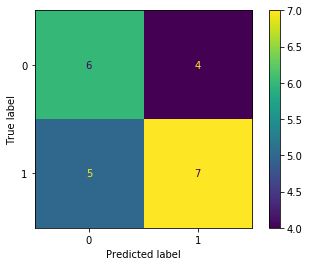

In [12]:
#Performance of Support Vector Classifier
plot_confusion_matrix( svm_1_model, 
                      input_scaled, 
                      target_data,
                      values_format = "d"
)

svm_1_model.score(input_scaled, 
                      target_data)

In [13]:
6/11, 7/11

(0.5454545454545454, 0.6363636363636364)

0.6818181818181818

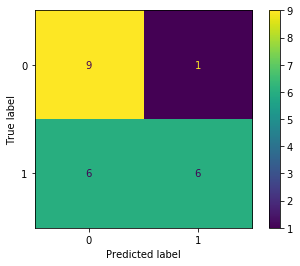

In [14]:
#Performance of Gausian Naive Bayes
plot_confusion_matrix( gnb_model, 
                      input_scaled, 
                      target_data,
                      values_format = "d"
)

gnb_model.score(input_scaled, 
                      target_data)


In [15]:
9/15, 6/7,

(0.6, 0.8571428571428571)

0.6818181818181818

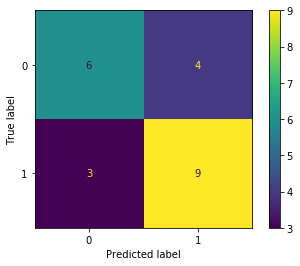

In [16]:
#Performance of Ensemble Model
plot_confusion_matrix( ensemble_model, 
                      predicts_input_e, target_data,
                      values_format = "d"
)

ensemble_model.score(predicts_input_e, target_data)

In [17]:
6/9, 9/13

(0.6666666666666666, 0.6923076923076923)

<Figure size 7200x5040 with 0 Axes>

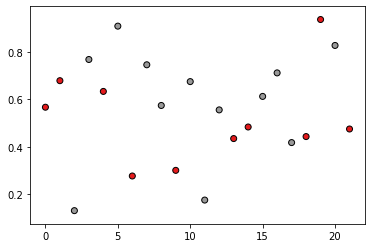

<Figure size 7200x5040 with 0 Axes>

In [18]:
ensemble_prob_train = ensemble_model.predict_proba(predicts_input_e)[:,1]
plt.scatter(np.arange(ensemble_prob_train.shape[0]), ensemble_prob_train, c=target_data, cmap=plt.cm.Set1,
            edgecolor='k')
plt.figure(2, figsize=(100, 70))

<Figure size 7200x5040 with 0 Axes>

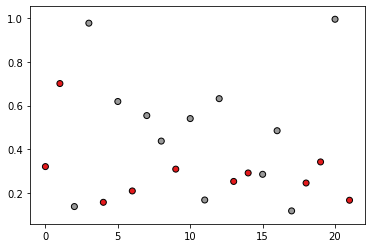

<Figure size 7200x5040 with 0 Axes>

In [19]:
gnb_prob_pred = gnb_model.predict_proba(input_scaled)[:,1]
plt.scatter(np.arange(gnb_prob_pred.shape[0]), gnb_prob_pred, c=target_data, cmap=plt.cm.Set1,
            edgecolor='k')
plt.figure(2, figsize=(100, 70))

<Figure size 7200x5040 with 0 Axes>

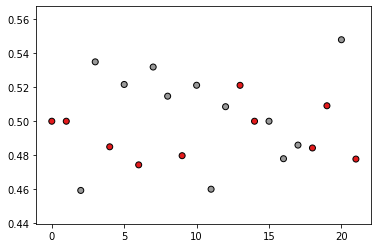

<Figure size 7200x5040 with 0 Axes>

In [20]:
svm_prob_pred = svm_1_model.predict_proba(input_scaled)[:,1]
plt.scatter(np.arange(svm_prob_pred.shape[0]), svm_prob_pred, c=target_data, cmap=plt.cm.Set1,
            edgecolor='k')
plt.figure(2, figsize=(100, 70))